# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
!pip install wget
!pip install zipfile36

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=51c083105d35062aa9806b0bc5e838fd88c6a7f81abbcca9b252294e9e71edec
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget
import zipfile
dir_path = 'content/'
filename=wget.download('https://ndownloader.figshare.com/files/21001311')
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("")
!rm fashion_mnist.zip
wget.download('https://raw.githubusercontent.com/automl/LCBench/master/api.py')
wget.download('https://raw.githubusercontent.com/infomon/Extrapolation-of-Learning-Curves/master/utils.py')
!mkdir content/models
!mkdir models

mkdir: cannot create directory ‘content/models’: No such file or directory


In [0]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from content.api import Benchmark
import content.utils as utils
import torch

In [4]:
bench_dir = dir_path+"fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [5]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [0]:
# Config
print("Config example:", train_data[0]["config"])

Config example: {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}


In [0]:
train_data[1]["config"]

{'activation': 'relu',
 'batch_size': 457,
 'cosine_annealing_T_max': 50,
 'cosine_annealing_eta_min': 1e-08,
 'imputation_strategy': 'mean',
 'learning_rate': 0.01239328605026128,
 'learning_rate_scheduler': 'cosine_annealing',
 'loss': 'cross_entropy_weighted',
 'max_dropout': 0.5472322491757223,
 'max_units': 950,
 'mlp_shape': 'funnel',
 'momentum': 0.16411425552061212,
 'network': 'shapedmlpnet',
 'normalization_strategy': 'standardize',
 'num_layers': 4,
 'optimizer': 'sgd',
 'weight_decay': 0.09762768273307641}

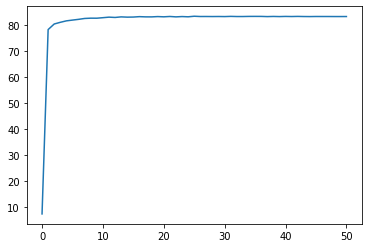

In [0]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

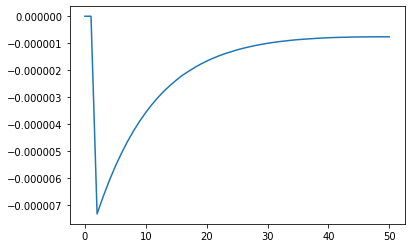

In [0]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

## A simple baseline

In [0]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [0]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [0]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523


In [0]:
device = utils.check_cuda()

In [0]:
train_data_loader = utils.prep_data(train_data, train_targets, batch_size=32,normalization_factor_temporal_data=[100])
val_data_loader = utils.prep_data(val_data, val_targets, batch_size=32,normalization_factor_temporal_data=[100])
test_data_loader = utils.prep_data(test_data, test_targets, batch_size=32,normalization_factor_temporal_data=[100])

In [0]:
class InterCondUniLSTM(torch.nn.Module):
    """An inter-conditional univariate LSTM that predicts from a single input sequence the final validation accuracy"""
    
    def __init__(self,input_size, hidden_size, output_size, 
                 num_layers=1, lstm_dropout=0, bidirectional=False,fc_dropout=0):
        super(InterCondUniLSTM,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm_dropout = lstm_dropout
        self.bidirectional = bidirectional
        self.fc_dropout = fc_dropout

        self.relu = torch.nn.functional.relu

        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=lstm_dropout, bidirectional=bidirectional)
        
        self.fc = torch.nn.Linear(self.hidden_size*10*2 if self.bidirectional else hidden_size*10,output_size)

    def forward(self,x):
        seq, config = x
        batch_size = seq.size(0)

        h0 = torch.zeros(self.num_layers*2 if self.bidirectional else self.num_layers, config.size()[0], self.hidden_size)
        c0 = torch.zeros(self.num_layers*2 if self.bidirectional else self.num_layers, config.size()[0], self.hidden_size)
        seq = torch.transpose(seq,1,0)
        seq = seq.unsqueeze(-1)

        inter_seq = []
        for i in range(10):
          inter_seq.append(torch.cat((seq[i],config),-1))
        inter_seq = torch.stack(inter_seq)

        lstm_out, _ = self.lstm(inter_seq,(h0,c0))
        lstm_out = lstm_out.permute(1,0,2)
        lstm_out = lstm_out.contiguous().view(batch_size,-1)
      
        forecast = self.fc(lstm_out)
        return forecast

In [0]:
def train(model, optimizer, criterion, clip=5):
    model.train()
    epoch_loss = []
    for val_acc, configs, targets in train_data_loader:
      optimizer.zero_grad()
      output = model([val_acc,configs])
      loss = criterion(output, targets)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
      optimizer.step()
      epoch_loss.append(loss.item())
    return np.array(epoch_loss).mean()

In [0]:
def evaluate(model, criterion):
  model.eval()
  epoch_loss = []
  with torch.no_grad():
    for val_acc, configs, targets in val_data_loader:
      output = model([val_acc, configs])
      loss = criterion(output, targets)
      epoch_loss.append(loss.item())
  return np.array(epoch_loss).mean()

In [0]:
def test(model, criterion):
    #model.load_state_dict(torch.load('content/models/model.pt'))
    model.eval()
    epoch_loss=[]
    with torch.no_grad():
      for val_acc, configs, targets in test_data_loader:
        output = model([val_acc, configs])
        loss = criterion(output, targets)
        epoch_loss.append(loss.item())
        
    return np.array(epoch_loss).mean()

In [0]:
def max_error(model, criterion):
    #model.load_state_dict(torch.load('content/models/model.pt'))
    model.eval()
    epoch_loss=[]
    with torch.no_grad():
      for val_acc, configs, targets in test_data_loader:
        output = model([val_acc, configs])
        loss = np.abs(output.detach().numpy()-targets.detach().numpy().reshape(-1,1))
        epoch_loss += loss.tolist()
        
    return np.array(epoch_loss)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
      torch.nn.init.uniform_(param.data, -0.08, 0.08)

In [183]:
input_size = 8
outcome_dim = 1
hidden_dim=35
num_layers=2
config_size = 7
bidirectional = True
lstm_dropout=0.5
fc_dropout=0.0

model = InterCondUniLSTM(input_size, hidden_dim, outcome_dim, num_layers,
                      lstm_dropout=lstm_dropout,bidirectional=bidirectional,fc_dropout=fc_dropout)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
model.apply(init_weights)

43261


InterCondUniLSTM(
  (lstm): LSTM(8, 35, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=700, out_features=1, bias=True)
)

In [0]:
epochs=200
lr=0.01
weight_decay = 10e-3
T_0 = int(epochs/4)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [0]:
from collections import namedtuple
train_stats = namedtuple("Stats",["train_loss", "val_loss"])
stats = train_stats(train_loss=np.zeros(epochs),
                     val_loss=np.zeros(epochs))

In [186]:
best_val_loss = float('inf')

for epoch in range(epochs):
  train_loss = train(model, optimizer, criterion)
  val_loss = evaluate(model, criterion)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(),"content/models/model_5.pt")    
    print('Val loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_val_loss,val_loss))
    best_val_loss = val_loss

  print(f'Epoch: {epoch}\t Train Loss: {train_loss:.3f}\t Val. Loss: {val_loss:.3f}')
  stats.train_loss[epoch] = train_loss
  stats.val_loss[epoch] = val_loss

  scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Val loss decreased (inf --> 65.781340).  Saving model ...
Epoch: 0	 Train Loss: 1377.565	 Val. Loss: 65.781
Val loss decreased (65.781340 --> 62.199132).  Saving model ...
Epoch: 1	 Train Loss: 76.590	 Val. Loss: 62.199
Val loss decreased (62.199132 --> 62.188114).  Saving model ...
Epoch: 2	 Train Loss: 79.774	 Val. Loss: 62.188
Epoch: 3	 Train Loss: 79.011	 Val. Loss: 88.090
Epoch: 4	 Train Loss: 83.941	 Val. Loss: 62.997
Val loss decreased (62.188114 --> 62.152932).  Saving model ...
Epoch: 5	 Train Loss: 80.615	 Val. Loss: 62.153
Epoch: 6	 Train Loss: 80.000	 Val. Loss: 62.777
Epoch: 7	 Train Loss: 79.289	 Val. Loss: 96.774
Epoch: 8	 Train Loss: 79.823	 Val. Loss: 63.923
Epoch: 9	 Train Loss: 80.042	 Val. Loss: 76.855
Epoch: 10	 Train Loss: 79.865	 Val. Loss: 92.278
Epoch: 11	 Train Loss: 78.971	 Val. Loss: 65.389
Epoch: 12	 Train Loss: 79.068	 Val. Loss: 101.373
Epoch: 13	 Train Loss: 80.002	 Val. Loss: 63.059
Epoch: 14	 Train Loss: 78.638	 Val. Loss: 72.071
Epoch: 15	 Train Loss:

In [0]:
np.save("content/train_stats_1.npy",stats)

In [0]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [189]:
test_loss = test(model, criterion)
print(test_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


63.4225355386734


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [190]:
model_list = []
for i in range(5):
  model = UnivariatMultiStepLSTM(input_size, hidden_dim, outcome_dim, num_layers,
                      lstm_dropout=lstm_dropout,bidirectional=bidirectional,fc_dropout=fc_dropout)
  model.load_state_dict(torch.load("content/model_"+str(i+1)+".pt"))
  model_list.append(model)

RuntimeError: ignored

In [0]:
test_losses = []
for i in range(5):
  test_losses.append(test(model_list[i],criterion))
print(np.array(test_losses).mean())

In [0]:
test_losses = []
for i in range(5):
  test_losses.append(test(model_list[i],RMSELoss))
print(np.array(test_losses).mean())

In [0]:
tmp = max_error(model_list[0],RMSELoss)

In [0]:
max_errors = []
for i in range(5):
  max_errors.append(max_error(model_list[i],RMSELoss).max())
print(np.array(max_errors).mean())

In [0]:
max_errors = []
for i in range(5):
  max_errors.append(max_error(model_list[i],RMSELoss))
print(np.array(max_errors).mean(axis=0).shape)
np.save("max_errors",np.array(max_errors).mean(axis=0))

In [0]:
def test_ensemble(model_list, criterion):
    #model.load_state_dict(torch.load('content/models/model.pt'))
    epoch_loss=[]
    with torch.no_grad():
      for val_acc, configs, targets in test_data_loader:
        output = []
        for model in model_list:
          model.eval()
          output.append(model([val_acc, configs]))
        output = torch.stack(output)
        output = torch.mean(output,dim=0)
        loss = criterion(output, targets.unsqueeze(-1))
        epoch_loss.append(loss.item())
        
    return np.array(epoch_loss).mean()

In [0]:
test_losses=test_ensemble(model_list,criterion)
print(test_losses)

In [0]:
test_losses=test_ensemble(model_list,RMSELoss)
print(test_losses)

In [0]:
def max_error_ensemble(model_list, criterion):
    epoch_loss=[]
    with torch.no_grad():
      for val_acc, configs, targets in test_data_loader:
        output = []
        for model in model_list:
          model.eval()
          output.append(model([val_acc, configs]))
        output = torch.stack(output)
        output = torch.mean(output,dim=0)
        loss = np.abs(output.detach().numpy()-targets.detach().numpy().reshape(-1,1))
        epoch_loss += loss.tolist()
        
    return np.array(epoch_loss)

In [0]:
test_losses=max_error_ensemble(model_list,RMSELoss)
print(test_losses.max())